# Exercises 2.7 from the QuantChallenge

> Come up with a trading strategy that makes money between the day ahead hourly prices and the intraday hourly prices. A strategy could be something like, always buy hour 19-20 on day ahead and sell it on intraday. You can look at certain times, weekdays, seasons, production levels of wind and solar. Your strategy can have a few input paramters such as time, renewable production etc, and then a decision output between two prices. I.e. when do you want to go long and short. Show the cumulative performance of this strategy with a 100 MW position. Show your results and quickly explain your reasoning of why you think this strategy might be a good idea and why it does or does not work.

## Disclamer

I am not a specialist in energy trading (yet).
I enjoyed this exercise greatly and did a lot of research to improve my trading strategies as I found the process extremely rewarding.
I also took a few liberties, like assuming I can resize my position for some strategies (instead of always using 100 MW)

> This notebook shows the final result of this analysis that took quite a bit of time.

## Structure:
- Load and clean the data
- Resample the data to hourly frequncy as the task asks for _hourly prices_
- My approach to developing strategies (weather, momentum, volatility)
- Code
- Analysis of the best strategies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [2]:
# load dataset (same as in previous notebook)
df = pd.read_excel("./database/analysis_task_data.xlsx")
# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])

print("Missing values:\n", df.isnull().sum())
print(f"unique time: {df['time'].is_unique}")
non_unique_values = df['time'].value_counts()[df['time'].value_counts() > 1].index.tolist()
print("Non-unique values:", non_unique_values)
print(f"Total values count {len(df)}")

df.drop_duplicates(subset='time', inplace=True, keep='first')
print(df.columns.tolist())

Missing values:
 hour                                                 0
time                                                 0
Wind Day Ahead Forecast [in MW]                      0
Wind Intraday Forecast [in MW]                       0
PV Day Ahead Forecast [in MW]                        0
PV Intraday Forecast [in MW]                         0
Day Ahead Price hourly [in EUR/MWh]                  0
Intraday Price Price Quarter Hourly  [in EUR/MWh]    0
Intraday Price Hourly  [in EUR/MWh]                  0
Imbalance Price Quarter Hourly  [in EUR/MWh]         0
dtype: int64
unique time: False
Non-unique values: [Timestamp('2021-10-31 02:45:00'), Timestamp('2021-10-31 02:30:00'), Timestamp('2021-10-31 02:15:00'), Timestamp('2021-10-31 02:00:00')]
Total values count 35040
['hour', 'time', 'Wind Day Ahead Forecast [in MW]', 'Wind Intraday Forecast [in MW]', 'PV Day Ahead Forecast [in MW]', 'PV Intraday Forecast [in MW]', 'Day Ahead Price hourly [in EUR/MWh]', 'Intraday Price Price Quarter 

In [3]:
# Set 'time' as the index for resampling
df.set_index('time', inplace=True)
# Resample to hourly using mean for continuous variables
df_hourly = df.resample('h').mean()
# Preserve 'Day Ahead price hourly' by forward-filling missing values
da_key = "Day Ahead Price hourly [in EUR/MWh]"
df_hourly[da_key] = df[da_key].resample('h').sum()/4. # since all 4 are the same
# Reset index to keep 'time' as a column
df_hourly.reset_index(inplace=True)

## Correlation Analysis

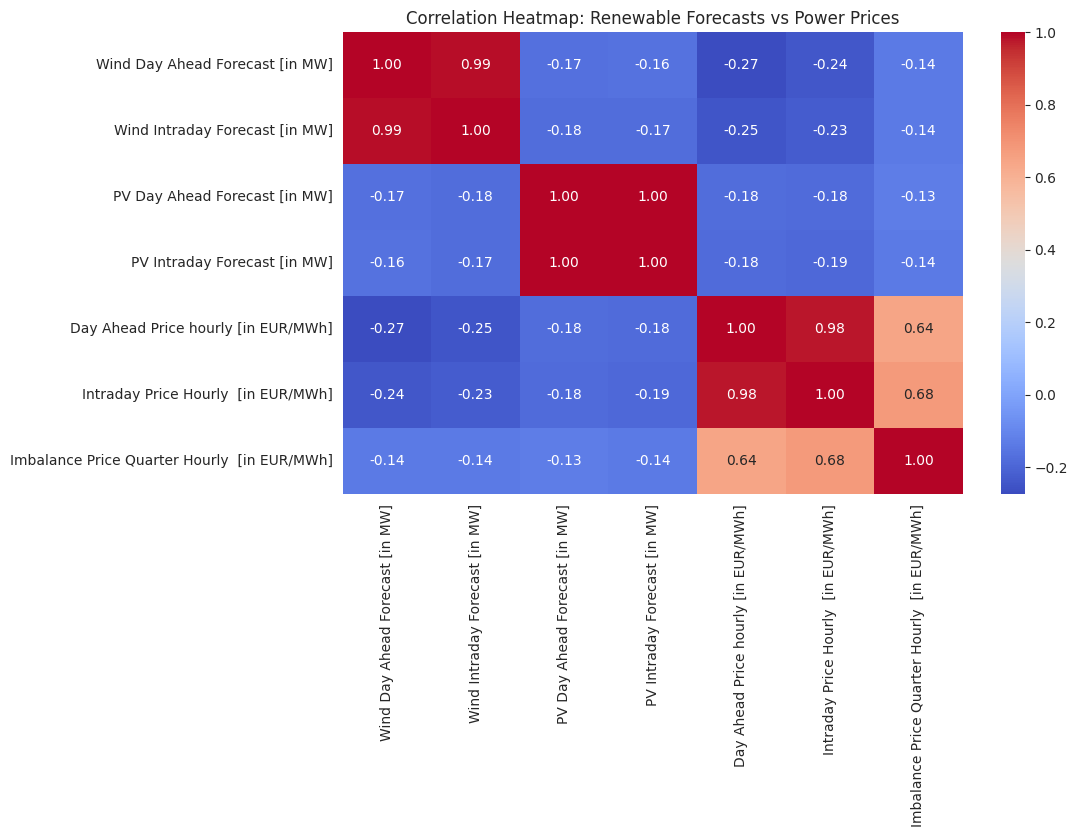

In [4]:
# Compute correlation matrix
correlation_matrix = df_hourly[[
    "Wind Day Ahead Forecast [in MW]",
    "Wind Intraday Forecast [in MW]",
    "PV Day Ahead Forecast [in MW]",
    "PV Intraday Forecast [in MW]",
    "Day Ahead Price hourly [in EUR/MWh]",
    "Intraday Price Hourly  [in EUR/MWh]",
    "Imbalance Price Quarter Hourly  [in EUR/MWh]"
]].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Renewable Forecasts vs Power Prices")
plt.show()

### Notes from the Correlation Heatmap:
1. Negative Correlation Between Wind Forecasts & Prices (merit order effect)
    - Both wind day-ahead and intraday wind forecasts are negatively correlated with day-ahead and intraday prices.
      This means that when more wind energy is forecasted, power prices tend to decrease.

2. Negative Correlation Between PV Forecasts & Prices
    - Similar to wind, PV (solar) forecasts show a negative correlation with prices, but it is weaker than wind. This suggests that high solar production also reduces prices but not as strongly as wind.

3. Strong Correlation Between Market Prices
    - The day-ahead price and intraday price are highly correlated, which is expected.
    - Imbalance price shows some correlation with intraday price but has more variance.


## Price Difference Analysis

In [5]:
# Calculate price differences between Day-Ahead and Intraday Hourly prices
df_hourly["Price Diff (Intraday - Day Ahead)"] = df_hourly["Intraday Price Hourly  [in EUR/MWh]"] - df_hourly["Day Ahead Price hourly [in EUR/MWh]"]
# Summary statistics of price differences
df_hourly["Price Diff (Intraday - Day Ahead)"].describe()

count    8759.000000
mean        1.140649
std        16.381785
min      -149.091700
25%        -5.132275
50%         0.163691
75%         6.436660
max       147.983032
Name: Price Diff (Intraday - Day Ahead), dtype: float64

### Key Observations from Price Differences:
- Mean Price Difference: ~1.14 EUR/MWh → On average, intraday prices are slightly higher than day-ahead prices.
- High Volatility: Standard deviation of ~16.38 EUR/MWh indicates significant fluctuations.
- Extreme Values: The price difference ranges from -149 EUR/MWh to +148 EUR/MWh, showing that large deviations occur.

## Trading Stratgies Development

Below is the result of several iterations/developments outside of this notebook.

I analyzed the correlation between renewable energy forecasts and power prices to develop multiple trading strategies. I first designed basic strategies based on wind and solar forecasts, incorporating price volatility to refine entry and exit conditions. I then introduced advanced strategies with risk-adjusted position sizing, leveraging forecast errors and dynamic volatility thresholds to optimize market exposure. Finally, I evaluated the strategies using cumulative profit analysis, volatility measures, and risk metrics such as Sharpe ratio and maximum drawdown to assess their performance and robustness.

After some reading on the matter I learned about __price drawdown__ that measures the peak-to-trough decline in a trading strategy’s cumulative profit that indicates the worst potential loss before recovery. I also read up on the __Sharpe ratio__ that evaluates risk-adjusted returns by comparing excess return over volatility, helping to assess whether a strategy's profits justify the risks taken. I included these metrics to ensure that the trading strategies not only generate returns but also manage downside risk effectively, maintaining a favorable risk-return balance.

## Code Structure

### Price difference

- Price Diff = Price Intraday - Price Day Ahead
- Compute rolling volatility if desired (e.g., rolling STD of 24 hours or 96 quarters).

#### Basic Strategies (1 - 5)

- Strategy 1 triggers a position when wind forecast exceeds the 75th percentile.
- Strategy 2 triggers a position when PV forecast exceeds the 75th percentile.
- Strategy 3 triggers when both wind & PV forecasts exceed the threshold.
- Strategy 4 refines Strategy 3 by also requiring low price volatility.
- Strategy 5 refines Strategy 3 by also requiring high price volatility.

#### Advanced Strategies (6 - 12)

- Strategy 6: Engage only under moderate (not too high, not too low) volatility and high wind+PV forecasts.
- Strategy 7: Position sizing depends on forecast error risk -- reduce or increase position based on high or low forecast error.
- Strategy 8: Peak hours strategy (e.g. 7 - 10h, 17 - 21h).
- Strategy 9: Momentum-based approach (if the rolling average of Price Diff is above a threshold, take a position).
- Strategy 10: Enhanced dynamic approach -- adjust position according to forecast error severity.
- Strategy 11 & 12: Position sizing based on volatility. In Strategy 12, the position is zero during very high volatility.
- Strategy 13 - 14: Combining momentum-based approach with renewables signals
- Strategy 15: attempt to combine momentum, volatility and renewables
#### Risk Metrics

For each strategy’s cumulative profit series, compute:
- Total Return
- Annualized Volatility
- Sharpe Ratio (simplified)
- Max Drawdown

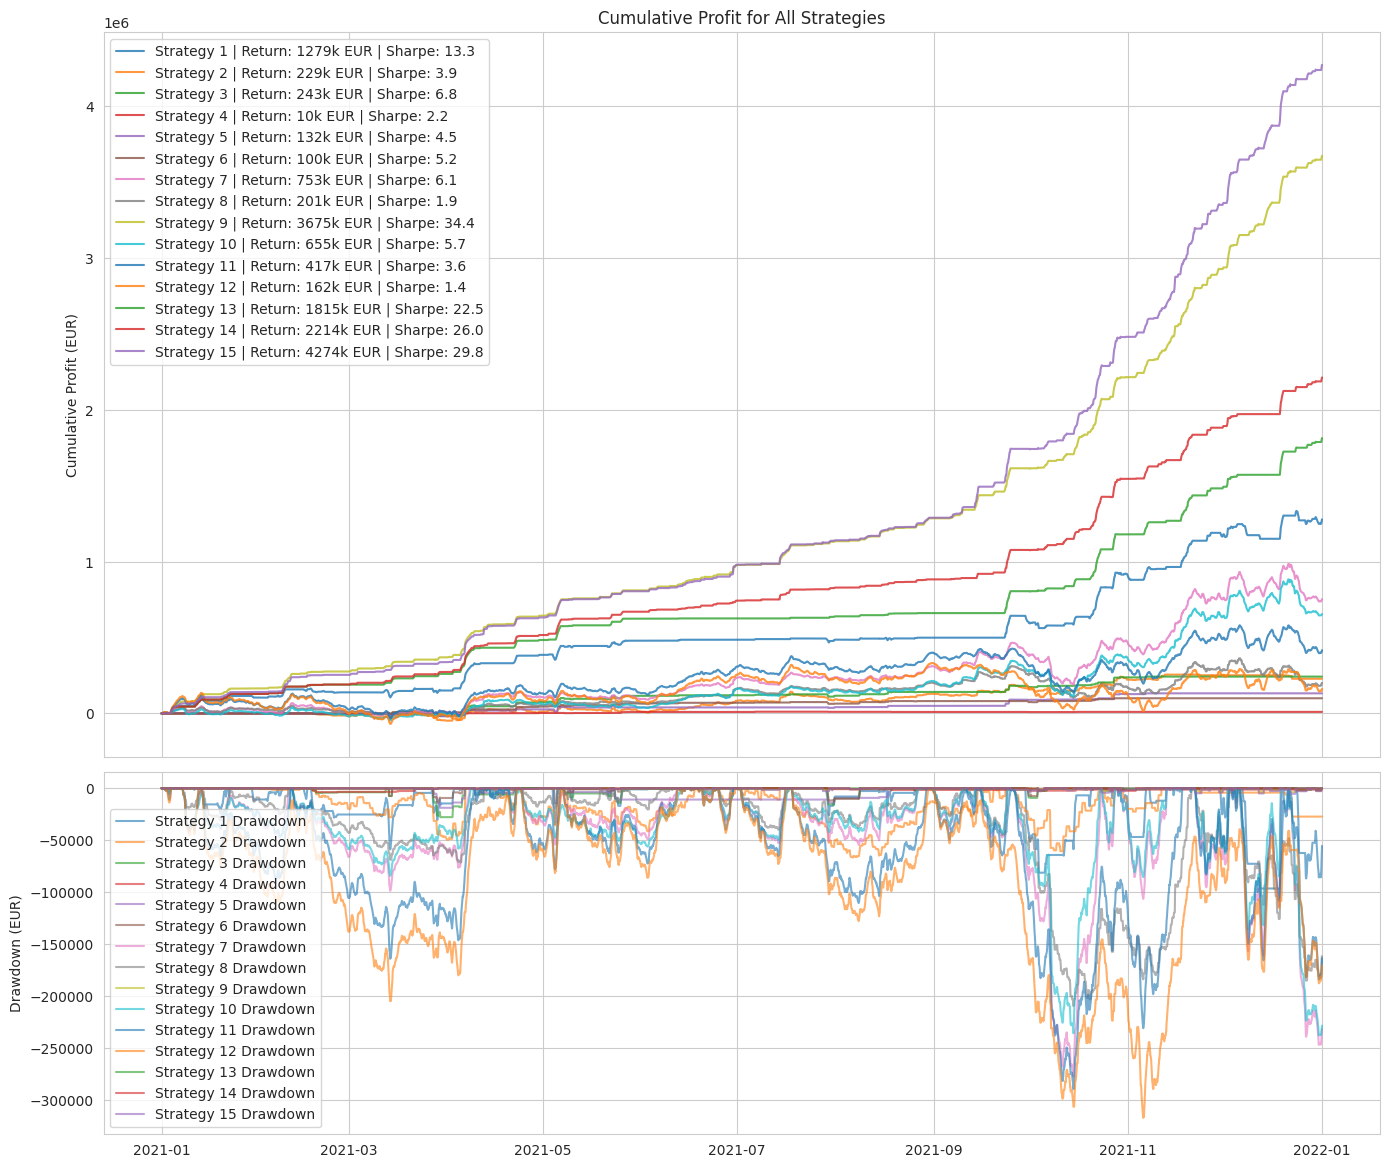

,Total Return (EUR),Annualized Volatility,Sharpe Ratio,Max Drawdown (EUR)
Strategy 1,1.279049e+06,19588.188199,13.330966,-96505.046647
Strategy 2,2.285461e+05,11991.800442,3.890973,-66856.229468
Strategy 3,2.427126e+05,7268.596798,6.817271,-27797.277362
Strategy 4,1.021931e+04,965.213732,2.161558,-3705.434193
Strategy 5,1.324470e+05,6039.085490,4.477542,-18780.039892
Strategy 6,1.000463e+05,3947.034774,5.174863,-12581.265054
Strategy 7,7.530166e+05,25065.109856,6.133434,-277571.853326
Strategy 8,2.010713e+05,21518.950530,1.907646,-209700.641745
Strategy 9,3.674776e+06,21836.120859,34.357708,-4046.105541
Strategy 10,6.545856e+05,23526.563325,5.680372,-238033.550159


In [6]:
def calculate_risk_metrics(profit_series: pd.Series) -> dict:
    """
    Computes several risk and performance metrics for a strategy's
    profit time series.
    """
    # Final profit value:
    total_return = profit_series.iloc[-1] if len(profit_series) > 0 else 0

    # Daily returns are the day-to-day changes in cumulative profit:
    daily_returns = profit_series.diff().dropna()

    # Standard deviation of daily returns:
    volatility = daily_returns.std()

    # Sharpe ratio (very simplified):
    sharpe_ratio = total_return / (volatility * np.sqrt(len(daily_returns))) if volatility != 0 else 0

    # Compute rolling maximum of the equity curve and resulting drawdown:
    rolling_max = profit_series.cummax()
    drawdown = profit_series - rolling_max
    max_drawdown = drawdown.min() if len(drawdown) > 0 else 0

    return {
        "Total Return (EUR)": total_return,
        "Annualized Volatility": volatility * np.sqrt(365), # assuming energy market never rests
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (EUR)": max_drawdown
    }

def compute_basic_strategies(df: pd.DataFrame, position_size: int = 100) -> pd.DataFrame:
    """
        Defines and computes the signals and profits for basic strategies (1-5).
        Returns the dataframe with new columns for each strategy's signals
        and cumulative profits.
    """

    # --- Determine thresholds for wind / PV day-ahead forecasts (75th quantile) ---
    high_wind_threshold = df["Wind Day Ahead Forecast [in MW]"].quantile(0.75) # percentile is a free (hyperparameter)
    high_pv_threshold = df["PV Day Ahead Forecast [in MW]"].quantile(0.75) # percentile is a free (hyperparameter)

    # --- Strategy 1: High Wind Threshold ---
    df["Strategy 1 Signal"] = df["Wind Day Ahead Forecast [in MW]"] > high_wind_threshold

    # ---- Strategy 2: High PV Threshold ---
    df["Strategy 2 Signal"] = df["PV Day Ahead Forecast [in MW]"] > high_pv_threshold

    # --- Strategy 3: High Wind AND High PV ---
    df["Strategy 3 Signal"] = ((df["Wind Day Ahead Forecast [in MW]"] > high_wind_threshold)
                               & (df["PV Day Ahead Forecast [in MW]"] > high_pv_threshold))

    # ---- Strategy 4: Strategy 3 + Low Volatility ---
    # (We assume Price Volatility is already computed outside)
    if not "Price Volatility" in df.columns: raise Exception("No price volatility column")

    low_vol_threshold = df["Price Volatility"].quantile(0.25) # can be a hyperparameter
    df["Strategy 4 Signal"] = df["Strategy 3 Signal"] & (df["Price Volatility"] < low_vol_threshold)

    # --- Strategy 5: Strategy 3 + High Volatility ---
    high_vol_threshold = df["Price Volatility"].quantile(0.75) # can be a hyperparameter
    df["Strategy 5 Signal"] = df["Strategy 3 Signal"] & (df["Price Volatility"] > high_vol_threshold)

    # --- Calculate Profits & Cumulative Profits ---
    for i in range(1, 6):
        # Multiply signal by (Intraday - Day Ahead) * position_size
        df[f"Strategy {i} Profit"] = (
                df[f"Strategy {i} Signal"]
                * df["Price Diff (Intraday - Day Ahead)"]
                * position_size
        )
        df[f"Cumulative Profit Strategy {i}"] = df[f"Strategy {i} Profit"].cumsum()

    return df

def compute_advanced_strategies(df: pd.DataFrame, position_size: int = 100) -> pd.DataFrame:
    """
    Defines and computes signals/positions for advanced strategies (6-12)
    and returns the updated dataframe.
    """
    # ---- Strategy 6: Moderate Volatility within Strategy 3 signal ---
    low_vol_threshold = df["Price Volatility"].quantile(0.25)
    high_vol_threshold = df["Price Volatility"].quantile(0.75)

    # moderate_volatility means not low and not high (but also not NaN):
    moderate_volatility_mask = (~df["Price Volatility"].isna()) & \
                               (df["Price Volatility"] >= low_vol_threshold) & \
                               (df["Price Volatility"] <= high_vol_threshold)
    df["Strategy 6 Signal"] = df["Strategy 3 Signal"] & moderate_volatility_mask

    # --- Forecast errors for risk adjustments ---
    df["Wind Forecast Error"] = df["Wind Intraday Forecast [in MW]"] - df["Wind Day Ahead Forecast [in MW]"]
    df["PV Forecast Error"] = df["PV Intraday Forecast [in MW]"] - df["PV Day Ahead Forecast [in MW]"]
    df["Wind Forecast Error Absolute"] = df["Wind Forecast Error"].abs()
    df["PV Forecast Error Absolute"] = df["PV Forecast Error"].abs()

    wind_error_75 = df["Wind Forecast Error Absolute"].quantile(0.75)
    pv_error_75   = df["PV Forecast Error Absolute"].quantile(0.75)
    wind_error_25 = df["Wind Forecast Error Absolute"].quantile(0.25)
    pv_error_25   = df["PV Forecast Error Absolute"].quantile(0.25)

    # --- Identify high / low forecast error quarters ---
    df["High Forecast Error"] = (
            (df["Wind Forecast Error Absolute"] > wind_error_75) |
            (df["PV Forecast Error Absolute"] > pv_error_75)
    )
    df["Low Forecast Error"] = (
            (df["Wind Forecast Error Absolute"] < wind_error_25) &
            (df["PV Forecast Error Absolute"] < pv_error_25)
    )

    # --- Strategy 7: Risk-Adjusted Trading Based on Forecast Errors ---
    df["Strategy 7 Position"] = position_size
    df.loc[df["High Forecast Error"], "Strategy 7 Position"] *= 0.5   # reduce to 50 MW
    df.loc[df["Low Forecast Error"], "Strategy 7 Position"] *= 1.5    # increase to 150 MW

    # --- Strategy 8: Peak Hour Trading (e.g., 7-10, 17-21) ---
    df["Hour"] = df["time"].dt.hour
    df["Strategy 8 Signal"] = (
            ((df["Hour"] >= 7) & (df["Hour"] <= 10)) | # morning (industry-driven peak)
            ((df["Hour"] >= 17) & (df["Hour"] <= 21)) # evening (houshold-driven peak)
    )

    # --- Strategy 9: Momentum-Based Trading (past 48-quarter average) center=False ensures the rolling mean only considers past values.
    df["Price Momentum"] = df["Price Diff (Intraday - Day Ahead)"].rolling(window=6, min_periods=1, center=False).mean()
    momentum_threshold = df["Price Momentum"].quantile(0.75)
    df["Strategy 9 Signal"] = df["Price Momentum"] > momentum_threshold

    # --- Strategy 10: Enhanced Dynamic Risk-Based Trading ---
    df["Strategy 10 Position"] = position_size
    df.loc[df["High Forecast Error"], "Strategy 10 Position"] *= 0.3   # 30 MW in high risk
    df.loc[df["Low Forecast Error"], "Strategy 10 Position"] *= 2.0    # 200 MW in low risk

    # --- Strategy 11 & 12: Dynamic Position Sizing Based on Volatility ---
    very_high_vol_threshold = df["Price Volatility"].quantile(0.90)

    df["Strategy 11 Position"] = position_size
    df.loc[df["Price Volatility"] > very_high_vol_threshold, "Strategy 11 Position"] = position_size * 0.3
    df.loc[df["Price Volatility"] < low_vol_threshold,       "Strategy 11 Position"] = position_size * 1.5

    df["Strategy 12 Position"] = position_size
    df.loc[df["Price Volatility"] > very_high_vol_threshold, "Strategy 12 Position"] = 0
    df.loc[df["Price Volatility"] < low_vol_threshold,       "Strategy 12 Position"] = position_size * 2.0

    # --- Strategy 13: Momentum + Renewable Energy Confirmation ---
    df["Strategy 13 Signal"] = df["Strategy 9 Signal"] & (df["Strategy 1 Signal"] )
    df["Strategy 14 Signal"] = df["Strategy 9 Signal"] & (df["Strategy 1 Signal"] | df["Strategy 2 Signal"] )

    # --- Strategy 14: Momentum + Renewables + Volatility ---
    df["Strategy 15 Position"] = position_size
    df.loc[df["Price Volatility"] > very_high_vol_threshold, "Strategy 15 Position"] *= 1.5  # Increase in high volatility
    df.loc[df["Price Volatility"] < low_vol_threshold, "Strategy 15 Position"] *= 0.5  # Decreased in low volatility
    df["Strategy 15 Position"] *= df["Strategy 9 Signal"]   # Only apply when Strategy 13 is active


    # ---- Calculate Profits & Cumulative Profits for Strategies with Position Changes ---
    for i in [7, 10, 11, 12, 15]:
        df[f"Strategy {i} Profit"] = (
                df[f"Strategy {i} Position"]
                * df["Price Diff (Intraday - Day Ahead)"]
        )
        df[f"Cumulative Profit Strategy {i}"] = df[f"Strategy {i} Profit"].cumsum()

    # ---- Calculate Profits for Strategies 6, 8, 9 (signal-based, fixed position) ---
    for i in [6, 8, 9, 13, 14]:
        df[f"Strategy {i} Profit"] = (
                df[f"Strategy {i} Signal"]
                * df["Price Diff (Intraday - Day Ahead)"]
                * position_size
        )
        df[f"Cumulative Profit Strategy {i}"] = df[f"Strategy {i} Profit"].cumsum()

    return df

def main(df, position_size:int):
    # ----------------------------------
    # Example: Load your data into a DataFrame
    # ----------------------------------
    # df = pd.read_excel("analysis_task_data.xlsx", parse_dates=["time"])
    # For demonstration, we'll create a small synthetic DataFrame:


    # Compute the key difference (Trading Mechanism)
    df["Price Diff (Intraday - Day Ahead)"] = df["Intraday Price Hourly  [in EUR/MWh]"] - df["Day Ahead Price hourly [in EUR/MWh]"]

    # Compute a rolling volatility measure (center=False ensures the rolling mean only considers past values.)
    df["Price Volatility"] = df["Price Diff (Intraday - Day Ahead)"].rolling(window=6, min_periods=1, center=False).std()

    # Basic & Advanced Strategies (simple weather-driven signals) & Volatility
    df = compute_basic_strategies(df, position_size=position_size)

    # Advanced, volatility driven with position resizing
    df = compute_advanced_strategies(df, position_size=position_size)


    # Calculate Risk Metrics
    all_strategies = [f"Strategy {i}" for i in range(1, 16)]
    risk_metrics = {}
    for strategy in all_strategies:
        cum_profit_col = f"Cumulative Profit {strategy}"
        if cum_profit_col in df.columns:
            risk_metrics[strategy] = calculate_risk_metrics(df[cum_profit_col])

    # Visualization of Cumulative Profits
    fig, ax = plt.subplots(2, 1, figsize=(14, 12), sharex=True,
                           gridspec_kw={'height_ratios': [2, 1]})

    # Panel 1: Cumulative Profits
    for strategy in risk_metrics.keys():
        label = f"{strategy} | Return: {risk_metrics[strategy]['Total Return (EUR)']/1e3:.0f}k EUR | Sharpe: {risk_metrics[strategy]['Sharpe Ratio']:.1f}"
        ax[0].plot(df["time"], df[f"Cumulative Profit {strategy}"], label=label, alpha=0.8)
    ax[0].set_ylabel("Cumulative Profit (EUR)")
    ax[0].set_title("Cumulative Profit for All Strategies")
    ax[0].legend()

    # Panel 3: Drawdowns for All Strategies
    for strategy in risk_metrics.keys():
        rolling_max = df[f"Cumulative Profit {strategy}"].cummax()
        drawdown = df[f"Cumulative Profit {strategy}"] - rolling_max
        ax[1].plot(df["time"], drawdown, label=f"{strategy} Drawdown", alpha=0.6)
    ax[1].set_ylabel("Drawdown (EUR)")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    risk_df = pd.DataFrame(risk_metrics).T
    return risk_df

risk_df = main(df_hourly, 100)
risk_df

### Study Analysis

From the analysis, _Strategy 15_ emerges as the most profitable approach, yielding the highest total return of 4.27 million EUR while maintaining a strong Sharpe ratio of 29.77 and moderate drawdowns. This strategy is a momentum-based strategy with increased position during high volatility.

Momentum-based strategies (9, 13, 14, and 14) demonstrate superior performance, with Strategy 9 (pure momentum-based) leading in risk-adjusted returns (Sharpe 34.36) and Strategy 14 (momentum & weather) achieving a solid balance between profitability and risk. Notably, Strategy 13 and 14, which integrate momentum with renewable energy signals, significantly improve upon standalone renewable-based strategies like Strategy 1 or 2, achieving higher returns with lower drawdowns. Traditional renewable strategies (1-5) perform modestly, but their profitability is limited due to market volatility, as seen in Strategy 2 and 3, which exhibit relatively high drawdowns. Overall, integrating momentum and volatility control mechanisms (as in Strategy 14 and 15) leads to optimal profitability and risk mitigation, making them the most effective approaches for trading in volatile power markets.









